### Importing Libraries

In [130]:
import numpy as np
import pandas as pd
import pandas_datareader as web
from pandas.plotting import scatter_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from datetime import timedelta

from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

plt.style.use('fivethirtyeight')

# pd.options.display.max_colwidth = 100
# pd.options.display.max_rows = 50

## Goals & Hypothesis of the Notebook

This Notebook aims at measuring hypothetical correlation between Musk Twitter activity and the stock price evolution as a whole.

Musk is an influent Twitter user (over 32M followers), and a very active one (8797 tweets gathered for the studied period).
Would he message have strong influence over his company's stock price ?

After analyzing its 8797 tweets as a whole, this study will focus mainly over Tesla related tweets (1100 tweets) and, among those, over the top 200 tweets in terms of interactions (i.e. sum of retweets, replies & favorites).


**Hypothesis**
- Tweets with important interaction rate assert that they convey an important piece of information (in theory business related). Each important Tesla related event which generates an important amount of interactions may have an impact on the stock, by transmitting key info on the company's business situation


- Tweets with positive business messages (product launch, increase of production etc.) should have positive impact over the stocks


- Controversal Tweets, as well as incorrect business figures, should have negative impact over the stock evolution

### Creating Functions

Creating several needed functions for the study : 
- MinMaxScaling_df_stock_tweets - MinMaxScaler to scale together Stock value & Twitter interactions
- create_Twitter_link & Twitter object : displaying Tweets within the notebook

In [131]:
def MinMaxScaling_df_stock_tweets(df):
    """
    Feeding a dataframe with MinMax Scaled data to be ploted
    
    Input : raw dataframe of 
    Output : dataframe with 3 new columns : 
                - Adj_scaled i.e MinMax Scaled Adjusted Close Stock Price
                - Tweet_interactions_scaled i.e MinMax Scaled Twitter interactions = Sum of Retweets & Replies
    """
    
    scaler = preprocessing.MinMaxScaler()
    df_temp = scaler.fit_transform(df)
    df_to_scale = pd.DataFrame(df_temp, columns=[['Adj Close', 'tweet_amount','tweet_interactions', 'favorites']])

    
    return df_to_scale

In [132]:
### When run, the code displays in HTML format each Tweet mentioned

class Tweet(object):
    """ Display Tweets issued from the embedded link on the platform"""
    
    def __init__(self, embed_str=None):
        self.embed_str = embed_str

    def _repr_html_(self):
        return self.embed_str

In [133]:
def create_Twitter_link(url):
    """Link of the tweet display
    Input : raw url of the tweet
    Output : url usable with the Tweet class object"""
    
    source_twitter="<blockquote class='twitter-tweet'><a href="+ url +"></a></blockquote> <script async src='https://platform.twitter.com/widgets.js' charset='utf-8'></script>1" 
    
    return source_twitter

# PART 1 - Data Collection, Data Analysis & plot generation

## Importing Tesla daily stock exchange values from 2010 IPO onwards

In [134]:
df_TSLA = pd.read_csv('../DataSets/Stocks_raw_data/TSLA_stocks_rate_2010-01-01_to_2020-03-08.csv', index_col='Date')

##### DataWrangling

Adding PCT indicator & reset index to datetime (currently considered an int)

In [135]:
df_TSLA.reset_index(drop=False , inplace=True)
df_TSLA['Date'] = pd.to_datetime(df_TSLA['Date'])
df_TSLA.set_index('Date', inplace=True)

In [136]:
df_TSLA['PCT_change'] = df_TSLA['Adj Close'].pct_change(fill_method='ffill')

In [137]:
df_TSLA

,High,Low,Open,Close,Volume,Adj Close,avg_price,PCT_change
Date,,,,,,,,
2010-06-29,25.000000,17.540001,19.000000,23.889999,18766300.0,23.889999,21.270000,NaN
2010-06-30,30.420000,23.299999,25.790001,23.830000,17187100.0,23.830000,26.860000,-0.002511
2010-07-01,25.920000,20.270000,25.000000,21.959999,8218800.0,21.959999,23.095000,-0.078473
2010-07-02,23.100000,18.709999,23.000000,19.200001,5139800.0,19.200001,20.905000,-0.125683
2010-07-06,20.000000,15.830000,20.000000,16.110001,6866900.0,16.110001,17.915000,-0.160938
2010-07-07,16.629999,14.980000,16.400000,15.800000,6921700.0,15.800000,15.804999,-0.019243
2010-07-08,17.520000,15.570000,16.139999,17.459999,7711400.0,17.459999,16.545000,0.105063
2010-07-09,17.900000,16.549999,17.580000,17.400000,4050600.0,17.400000,17.224999,-0.003436
2010-07-12,18.070000,17.000000,17.950001,17.049999,2202500.0,17.049999,17.535000,-0.020115


Adding PCT_change i.e. percetange change evolution from one day to another to measure the general trend of each day

In [138]:
df_TSLA

,High,Low,Open,Close,Volume,Adj Close,avg_price,PCT_change
Date,,,,,,,,
2010-06-29,25.000000,17.540001,19.000000,23.889999,18766300.0,23.889999,21.270000,NaN
2010-06-30,30.420000,23.299999,25.790001,23.830000,17187100.0,23.830000,26.860000,-0.002511
2010-07-01,25.920000,20.270000,25.000000,21.959999,8218800.0,21.959999,23.095000,-0.078473
2010-07-02,23.100000,18.709999,23.000000,19.200001,5139800.0,19.200001,20.905000,-0.125683
2010-07-06,20.000000,15.830000,20.000000,16.110001,6866900.0,16.110001,17.915000,-0.160938
2010-07-07,16.629999,14.980000,16.400000,15.800000,6921700.0,15.800000,15.804999,-0.019243
2010-07-08,17.520000,15.570000,16.139999,17.459999,7711400.0,17.459999,16.545000,0.105063
2010-07-09,17.900000,16.549999,17.580000,17.400000,4050600.0,17.400000,17.224999,-0.003436
2010-07-12,18.070000,17.000000,17.950001,17.049999,2202500.0,17.049999,17.535000,-0.020115


In [139]:
df_TSLA.dtypes

High          float64
Low           float64
Open          float64
Close         float64
Volume        float64
Adj Close     float64
avg_price     float64
PCT_change    float64
dtype: object

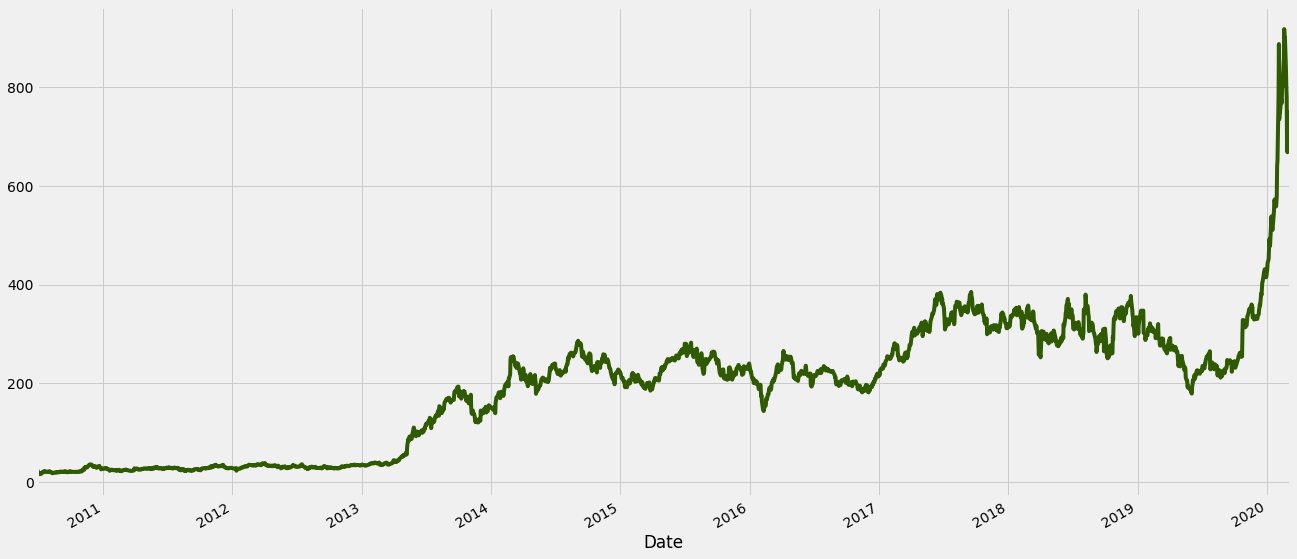

In [140]:
df_TSLA['Adj Close'].plot(figsize=(20,10), c=np.random.rand(3))

## 3 - Comparison of Stock Price VS. Twitter activity

### XXX-1. Importing Musk Tweets

In [141]:
# musk_tweets = pd.read_csv('../DataSets/df_musk_tweets.csv', index_col='Unnamed: 0')

In [142]:
df_musk_general_tweets_groupby = pd.read_csv('../DataSets/Twitter_data/df_musk_general_tweets_groupby.csv')

In [143]:
df_musk_general_tweets_groupby['date'] = pd.to_datetime(df_musk_general_tweets_groupby['date'])

Merging Adjusted close price dataframe with the amount of Tweets from Elon Musk

In [144]:
# Converting Date column to datetime
# musk_tweets_groupby['date'] = pd.to_datetime(musk_tweets_groupby['date'])

In [145]:
df_TSLA_reduce = df_TSLA.reset_index()

df_TSLA_reduce = df_TSLA_reduce [['Date', 'Adj Close', 'PCT_change']]

#renaming column Date to date for future merge 
df_TSLA_reduce.columns = ('date', 'Adj Close', 'PCT_change')

df_TSLA_reduce['date'] = pd.to_datetime(df_TSLA_reduce['date'])

### XXX-2. Comparing to all 8797 Musk Tweets

Analyzing all 8797 independently of the content to see whether Musk's Twitter activity has an overall impact on the stock evolution

Creating a new dataframe (df_general_tweets), merging all 8797 with the evolution of stocks (left join on the daily stock activity)

##### Data Wrangling
Filling NaN (days without tweets) with 0

In [146]:
df_general_tweets = pd.merge(df_TSLA_reduce, df_musk_general_tweets_groupby, how='left', on='date')

df_general_tweets.fillna(value=0, inplace=True)

df_general_tweets

,date,Adj Close,PCT_change,text,retweets,replies,favorites,tweet_interactions
0,2010-06-29,23.889999,0.000000,0.0,0.0,0.0,0.0,0.0
1,2010-06-30,23.830000,-0.002511,0.0,0.0,0.0,0.0,0.0
2,2010-07-01,21.959999,-0.078473,0.0,0.0,0.0,0.0,0.0
3,2010-07-02,19.200001,-0.125683,0.0,0.0,0.0,0.0,0.0
4,2010-07-06,16.110001,-0.160938,0.0,0.0,0.0,0.0,0.0
5,2010-07-07,15.800000,-0.019243,0.0,0.0,0.0,0.0,0.0
6,2010-07-08,17.459999,0.105063,0.0,0.0,0.0,0.0,0.0
7,2010-07-09,17.400000,-0.003436,0.0,0.0,0.0,0.0,0.0
8,2010-07-12,17.049999,-0.020115,0.0,0.0,0.0,0.0,0.0
9,2010-07-13,18.139999,0.063930,0.0,0.0,0.0,0.0,0.0


In [147]:
df_general_tweets.drop(columns = ['retweets', 'replies'], inplace=True)

In [148]:
df_TSLA_tweets_to_scale = df_general_tweets.copy()

df_TSLA_tweets_to_scale

,date,Adj Close,PCT_change,text,favorites,tweet_interactions
0,2010-06-29,23.889999,0.000000,0.0,0.0,0.0
1,2010-06-30,23.830000,-0.002511,0.0,0.0,0.0
2,2010-07-01,21.959999,-0.078473,0.0,0.0,0.0
3,2010-07-02,19.200001,-0.125683,0.0,0.0,0.0
4,2010-07-06,16.110001,-0.160938,0.0,0.0,0.0
5,2010-07-07,15.800000,-0.019243,0.0,0.0,0.0
6,2010-07-08,17.459999,0.105063,0.0,0.0,0.0
7,2010-07-09,17.400000,-0.003436,0.0,0.0,0.0
8,2010-07-12,17.049999,-0.020115,0.0,0.0,0.0
9,2010-07-13,18.139999,0.063930,0.0,0.0,0.0


Creating a Scaler and feeding the Tweet dataframe with the scaled value to have both original & scaled value

In [149]:
df_TSLA_tweets_to_scale.set_index('date', inplace=True)

In order to compare such different measures (Stock value in hundreds of dollars) and amount of tweets (in units of tweets)

In [150]:
scaler_all_tweets = preprocessing.MinMaxScaler()

In [151]:
df_TSLA_tweets_to_scale = scaler_all_tweets.fit_transform(df_TSLA_tweets_to_scale)

In [152]:
df_TSLA_tweets_scaled = pd.DataFrame(df_TSLA_tweets_to_scale, columns=[['Adj Close','tweet_amount', 'favorites' ,'tweet_interactions', 'PCT_change']])

In [153]:
df_TSLA_tweets_scaled

,Adj Close,tweet_amount,favorites,tweet_interactions,PCT_change
0,0.008973,0.442048,0.000000,0.000000,0.000000
1,0.008906,0.436304,0.000000,0.000000,0.000000
2,0.006832,0.262569,0.000000,0.000000,0.000000
3,0.003771,0.154592,0.000000,0.000000,0.000000
4,0.000344,0.073959,0.000000,0.000000,0.000000
5,0.000000,0.398037,0.000000,0.000000,0.000000
6,0.001841,0.682343,0.000000,0.000000,0.000000
7,0.001775,0.434188,0.000000,0.000000,0.000000
8,0.001386,0.396042,0.000000,0.000000,0.000000
9,0.002595,0.588265,0.000000,0.000000,0.000000


Plotting general tweet impact on the stock

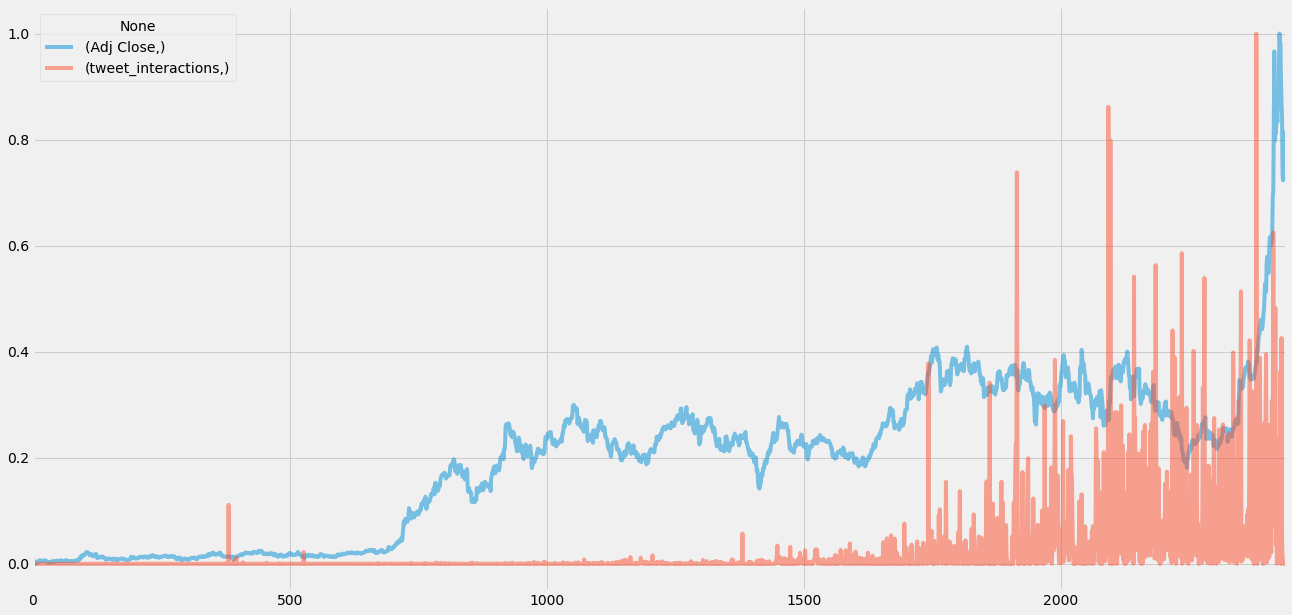

In [154]:
df_TSLA_tweets_scaled[['Adj Close', 'tweet_interactions']].plot(alpha=0.5, figsize=(20,10))

Creating a Correlation matrix to measure the potential influence of the tweet amount (i.e 8797 ) & tweet interactions over the stock price.

The hypothesis being that this amount should have a low influence overall

Correlation matrix

In [155]:
corr_general_tweets = df_TSLA_tweets_scaled.corr()

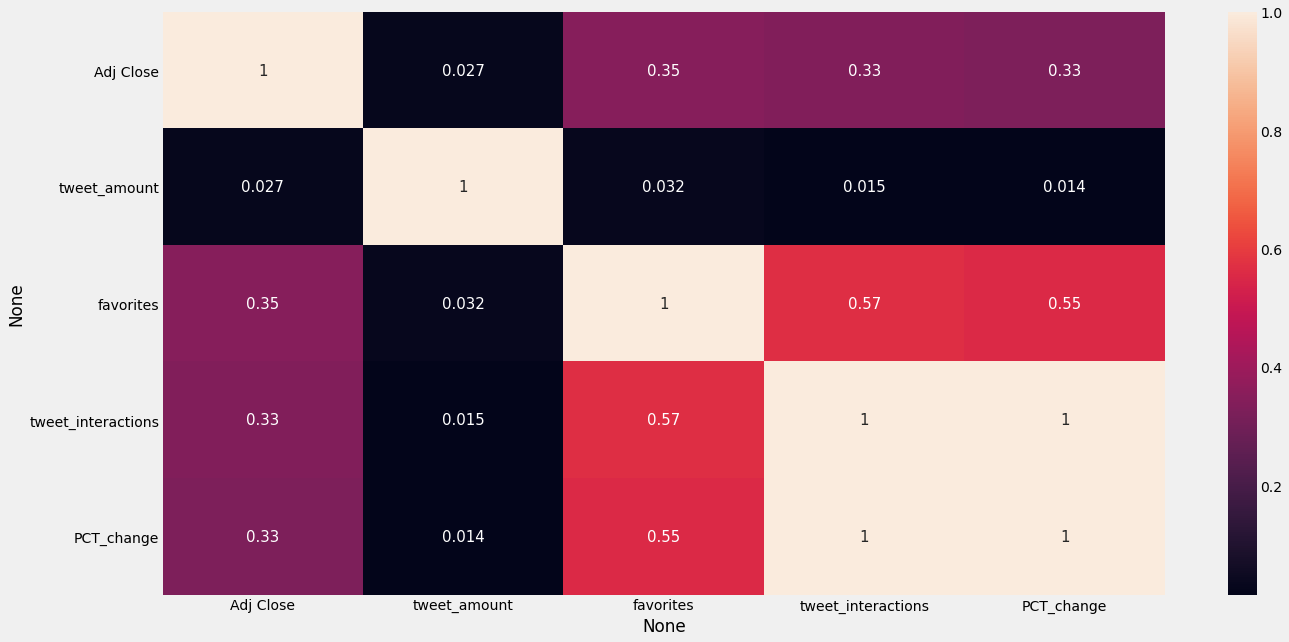

In [156]:
plt.figure(figsize=(20,10))
sns.heatmap(corr_general_tweets, annot=True, annot_kws={"size": 15})

## Merging Tesla related tweets with Tesla stock evolution

Now we shall focus on the specific tweets mentioning Tesla, or Tesla related (as defined in the Twitter scraper notebook).

The hypothesis being here that there should be a stronger correlation between the tweets & the stock evolution, when Tesla is mentioned.

In [157]:
df_musk_Tesla_tweets_groupby = pd.read_csv('../DataSets/Twitter_data/df_musk_Tesla_tweets_groupby.csv')

In [158]:
df_musk_Tesla_tweets_groupby['date'] = pd.to_datetime(df_musk_Tesla_tweets_groupby['date'])

In [159]:
df_TSLA_related_tweets = pd.merge(df_TSLA_reduce, df_musk_Tesla_tweets_groupby, how='left', on='date')

df_TSLA_related_tweets.fillna(value=0, inplace=True)

df_TSLA_related_tweets

,date,Adj Close,PCT_change,text,retweets,replies,favorites,tweet_interactions
0,2010-06-29,23.889999,0.000000,0.0,0.0,0.0,0.0,0.0
1,2010-06-30,23.830000,-0.002511,0.0,0.0,0.0,0.0,0.0
2,2010-07-01,21.959999,-0.078473,0.0,0.0,0.0,0.0,0.0
3,2010-07-02,19.200001,-0.125683,0.0,0.0,0.0,0.0,0.0
4,2010-07-06,16.110001,-0.160938,0.0,0.0,0.0,0.0,0.0
5,2010-07-07,15.800000,-0.019243,0.0,0.0,0.0,0.0,0.0
6,2010-07-08,17.459999,0.105063,0.0,0.0,0.0,0.0,0.0
7,2010-07-09,17.400000,-0.003436,0.0,0.0,0.0,0.0,0.0
8,2010-07-12,17.049999,-0.020115,0.0,0.0,0.0,0.0,0.0
9,2010-07-13,18.139999,0.063930,0.0,0.0,0.0,0.0,0.0


In [160]:
df_TSLA_related_tweets.drop(columns = ['retweets', 'replies'], inplace=True)

In [161]:
df_TSLA_tweets_to_scale = df_TSLA_related_tweets.copy()

In [162]:
df_TSLA_tweets_to_scale

,date,Adj Close,PCT_change,text,favorites,tweet_interactions
0,2010-06-29,23.889999,0.000000,0.0,0.0,0.0
1,2010-06-30,23.830000,-0.002511,0.0,0.0,0.0
2,2010-07-01,21.959999,-0.078473,0.0,0.0,0.0
3,2010-07-02,19.200001,-0.125683,0.0,0.0,0.0
4,2010-07-06,16.110001,-0.160938,0.0,0.0,0.0
5,2010-07-07,15.800000,-0.019243,0.0,0.0,0.0
6,2010-07-08,17.459999,0.105063,0.0,0.0,0.0
7,2010-07-09,17.400000,-0.003436,0.0,0.0,0.0
8,2010-07-12,17.049999,-0.020115,0.0,0.0,0.0
9,2010-07-13,18.139999,0.063930,0.0,0.0,0.0


Creating a Scaler and feeding the Tweet dataframe with the scaled value to have both original & scaled value

In [163]:
df_TSLA_tweets_to_scale.set_index('date', inplace=True)

In order to compare such different measures (Stock value in hundreds of dollars) and amount of tweets (in units of tweets)

In [164]:
scaler_TSLA_tweets = preprocessing.MinMaxScaler()

In [165]:
df_TSLA_tweets_to_scale = scaler_TSLA_tweets.fit_transform(df_TSLA_tweets_to_scale)

In [166]:
df_TSLA_related_tweets_scaled = pd.DataFrame(df_TSLA_tweets_to_scale, columns=[['Adj Close','PCT_change', 'tweet_amount', 'favorites','tweet_interactions']])

In [167]:
df_TSLA_related_tweets_scaled

,Adj Close,PCT_change,tweet_amount,favorites,tweet_interactions
0,0.008973,0.442048,0.000000,0.000000,0.000000
1,0.008906,0.436304,0.000000,0.000000,0.000000
2,0.006832,0.262569,0.000000,0.000000,0.000000
3,0.003771,0.154592,0.000000,0.000000,0.000000
4,0.000344,0.073959,0.000000,0.000000,0.000000
5,0.000000,0.398037,0.000000,0.000000,0.000000
6,0.001841,0.682343,0.000000,0.000000,0.000000
7,0.001775,0.434188,0.000000,0.000000,0.000000
8,0.001386,0.396042,0.000000,0.000000,0.000000
9,0.002595,0.588265,0.000000,0.000000,0.000000


Creating new columns, fed by  the scaled value, to the original df_TSLA_related_tweets

In [168]:
df_TSLA_related_tweets['Adj_scaled'] = df_TSLA_related_tweets_scaled['Adj Close']

df_TSLA_related_tweets['tweet_amount_scaled'] = df_TSLA_related_tweets_scaled['tweet_amount']

df_TSLA_related_tweets['tweet_interactions_scaled'] = df_TSLA_related_tweets_scaled['tweet_interactions']

In [169]:
df_TSLA_related_tweets.set_index('date', inplace=True)

In [170]:
df_TSLA_related_tweets

,Adj Close,PCT_change,text,favorites,tweet_interactions,Adj_scaled,tweet_amount_scaled,tweet_interactions_scaled
date,,,,,,,,
2010-06-29,23.889999,0.000000,0.0,0.0,0.0,0.008973,0.000000,0.000000
2010-06-30,23.830000,-0.002511,0.0,0.0,0.0,0.008906,0.000000,0.000000
2010-07-01,21.959999,-0.078473,0.0,0.0,0.0,0.006832,0.000000,0.000000
2010-07-02,19.200001,-0.125683,0.0,0.0,0.0,0.003771,0.000000,0.000000
2010-07-06,16.110001,-0.160938,0.0,0.0,0.0,0.000344,0.000000,0.000000
2010-07-07,15.800000,-0.019243,0.0,0.0,0.0,0.000000,0.000000,0.000000
2010-07-08,17.459999,0.105063,0.0,0.0,0.0,0.001841,0.000000,0.000000
2010-07-09,17.400000,-0.003436,0.0,0.0,0.0,0.001775,0.000000,0.000000
2010-07-12,17.049999,-0.020115,0.0,0.0,0.0,0.001386,0.000000,0.000000


Let's plot the evolution of the stock with the evolution of the Tesla related tweet interactions to see whether ther would be a stronger correlation.

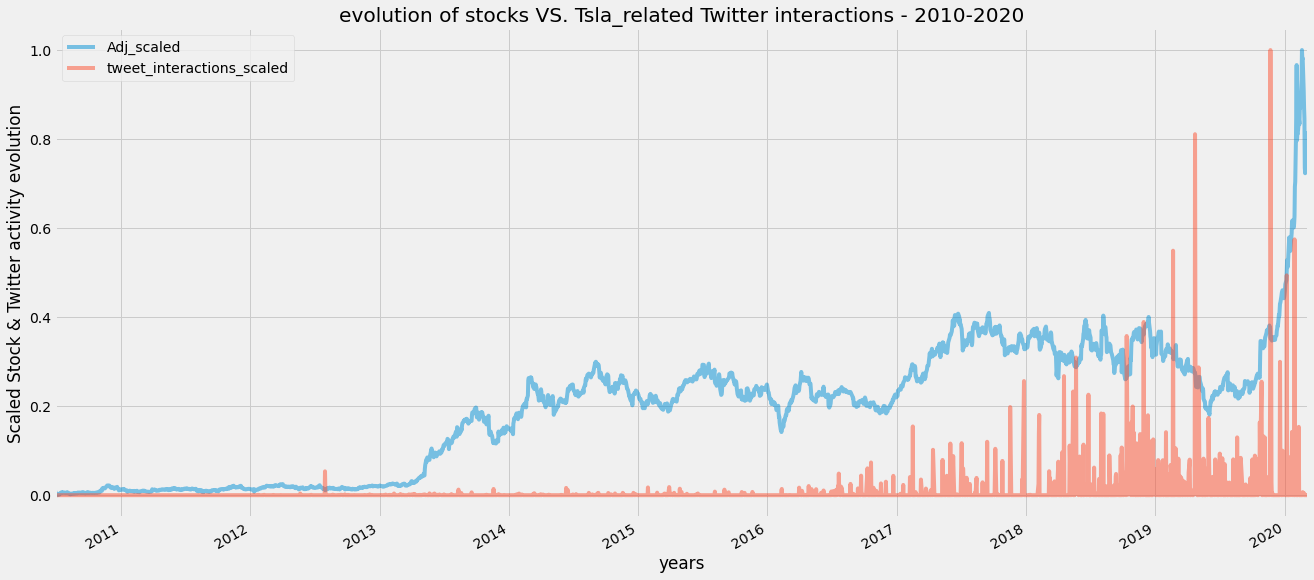

In [171]:
ax1 = df_TSLA_related_tweets[['Adj_scaled', 'tweet_interactions_scaled']].plot(alpha=0.5, figsize=(20, 10), 
    title='evolution of stocks VS. Tsla_related Twitter interactions - 2010-2020')
ax1.set_xlabel('years')
ax1.set_ylabel('Scaled Stock & Twitter activity evolution')
plt.savefig('../DataSets/Twitter_data/2010-2020 - TSLA_stock_evolution_VS._1100_TSLA_related_tweets._stock.png' )

##### Correlation Matrix on Tesla related tweets

The overall correlation Matrix remains identical to the original one, stating that the 

NB : the amount of '0', for each day without tweet has a strong impact on the overall dynamic.

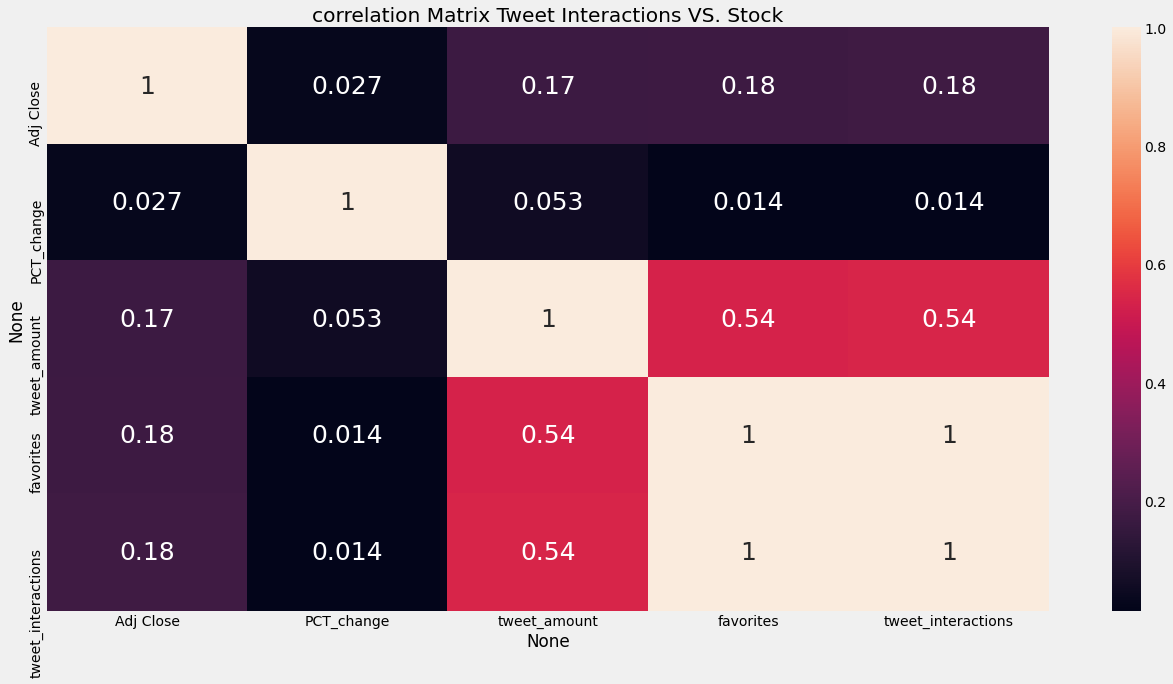

In [172]:
corr_TSLA_related_tweets = df_TSLA_related_tweets_scaled.corr()

plt.figure(figsize=(20,10))
sns.heatmap(corr_TSLA_related_tweets, annot=True, annot_kws={"size": 25})
plt.title('correlation Matrix Tweet Interactions VS. Stock')
plt.savefig('../DataSets/Twitter_data/Correlation_Matrix_Twitter_VS._stock.png' , dpi=fig.dpi)


### Conclusion

The result of those two simulation is overall similar, when taking the entire 2010-2020 studied period

To be noted :
- whereas the first years, up to 2016 do not demonstrate a strong relation, the stock evolving constantly without any specific evolution of the tweet interactions. 
- when focusing on the second period from 2016 onwards, it appears that there might be a stronger correlation, which will be studied in the second part of this notebook.

#### Plotting Tesla related tweets impact on the stock

Here we can see how Tesla related Tweets may have a bigger impact due to 

For the ploting, let's reset index of the df_TSLA_related_tweets to date, in order to be able to LOC indexes on a specific time period

In [173]:
# df_TSLA_related_tweets.set_index('date', inplace=True)

Ploting the most interesting period, the 2018 - 2020 period

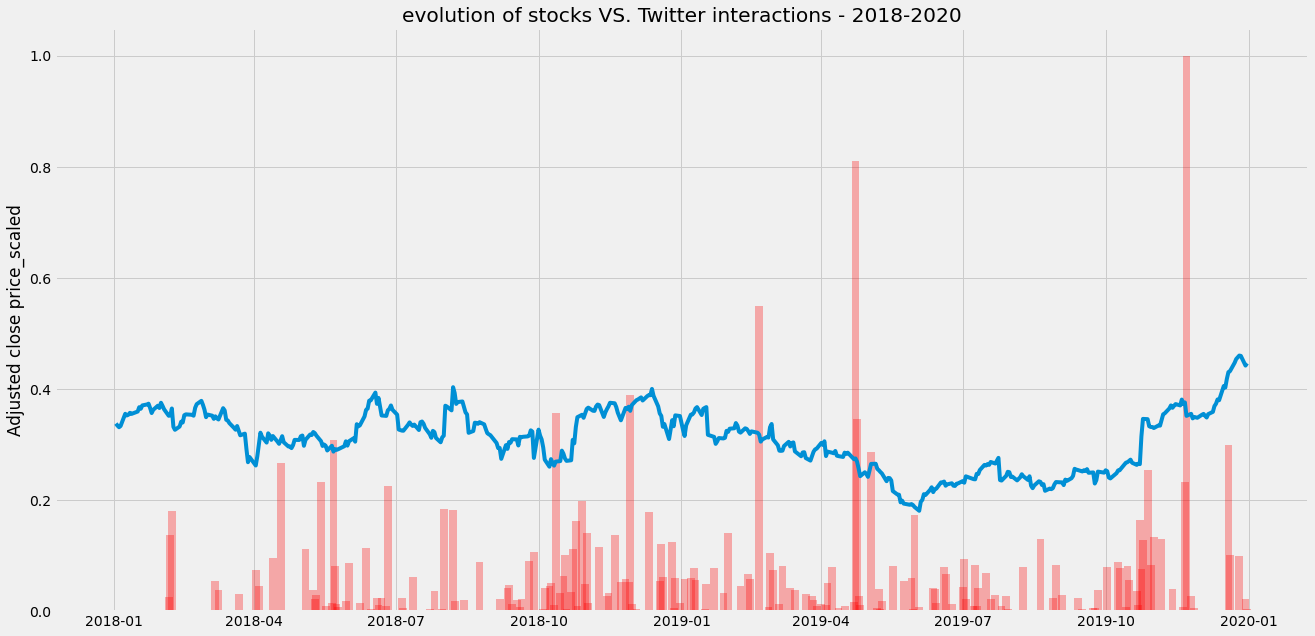

In [174]:
sliced_df_2018_2020 = df_TSLA_related_tweets['2018-01-01':'2020-01-01']

plt.figure(figsize=(20, 10))
plt.plot(sliced_df_2018_2020.Adj_scaled)
plt.bar(x= sliced_df_2018_2020.index, height=sliced_df_2018_2020.tweet_interactions_scaled, width=5, color='r', alpha=0.3)
plt.title('evolution of stocks VS. Twitter interactions - 2018-2020')
plt.ylabel('Adjusted close price_scaled')
plt.savefig(f'../DataSets/Twitter_data/2018-2018_Twitter_activity_stock_evolution.png' , dpi=150)

plt.show()

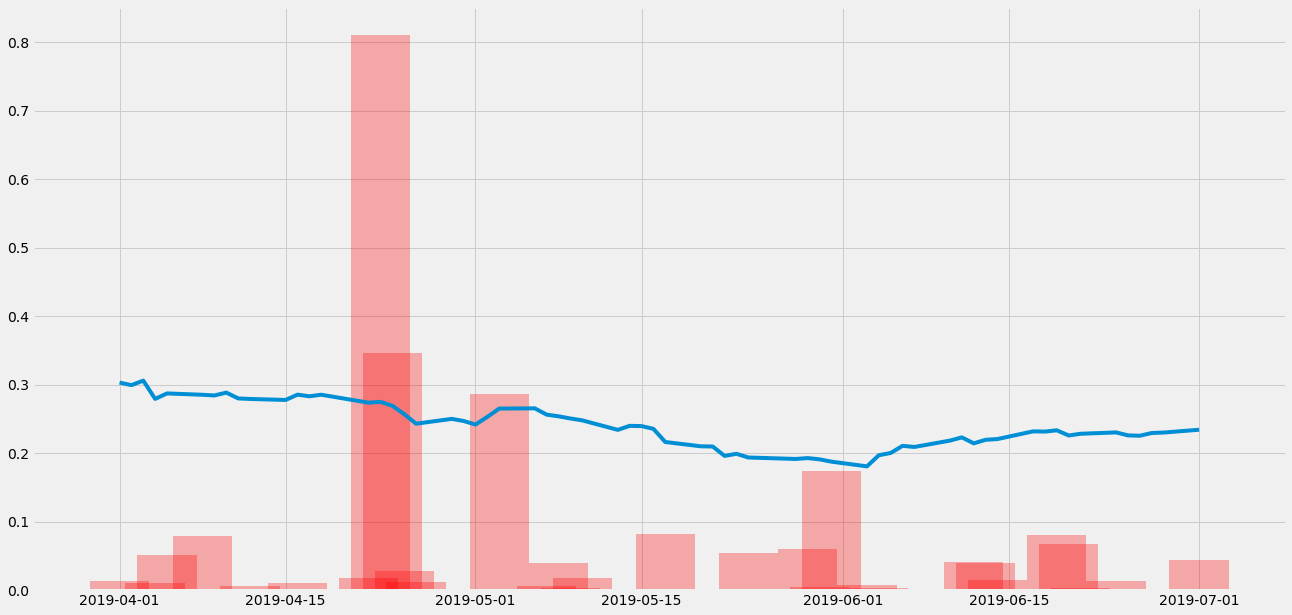

In [175]:
sliced_df_2019_2020 = df_TSLA_related_tweets['2019-04-01':'2019-07-01']

plt.figure(figsize=(20, 10))
plt.plot(sliced_df_2019_2020.Adj_scaled)
plt.bar(x= sliced_df_2019_2020.index, height=sliced_df_2019_2020.tweet_interactions_scaled, width=5, color='r', alpha=0.3)
plt.show()

### 1- 2 Focusing on top interactions tweets

In this part, we shall focus on the top 200 influential individual tweets in order to measure whether one of those 200 may have had strong impact over the stock price.

Be it for indivual tweets (cf. df top_200_TSLA_tweets_interactions) or grouped tweets by date (cf. Top_50_TSLA_tweets), all tweets having generated the most interactions are issued on the aforementioned period from 2018 onwards.

We shall focus on analyzing those tweets in the following part.
The tweets are sorted in a descending order, from the ones having generated the most interactions to the least

In [176]:
top_200_TSLA_tweets_interactions = pd.read_csv('../DataSets/Twitter_data/top_200_TSLA_tweets_interactions.csv')

In [177]:
top_200_TSLA_tweets_interactions

,date,text,retweets,replies,favorites,tweet_interactions,permalink,to,hashtags,mentions
0,2019-11-24,Cybertruck pulls F-150 uphill,116793,16494,670614,803901,https://twitter.com/elonmusk/status/1198751258384818176,NaN,NaN,NaN
1,2019-11-22,Nobody *expects* the Cybertruck,48265,14548,438698,501511,https://twitter.com/elonmusk/status/1197768038415659008,NaN,NaN,NaN
2,2020-01-29,A friend just sent me this excerpt from a Tesla blog I wrote 14 years ago,37648,4488,366829,408965,https://twitter.com/elonmusk/status/1222597315023654912,NaN,NaN,NaN
3,2019-11-23,Franz throws steel ball at Cybertruck window right before launch. Guess we have some improvement...,38694,8478,328580,375752,https://twitter.com/elonmusk/status/1198090787520598016,NaN,NaN,NaN
4,2020-01-07,At Tesla Giga Shanghai NSFW!!,37175,7420,306826,351421,https://twitter.com/elonmusk/status/1214483582363693057,NaN,NaN,NaN
5,2019-04-23,"Tesla is going to develop a quiet, electric leafblower",24939,10392,314387,349718,https://twitter.com/elonmusk/status/1120831425169674240,NaN,NaN,NaN
6,2019-11-23,"146k Cybertruck orders so far, with 42% choosing dual, 41% tri & 17% single motor",24714,7734,303872,336320,https://twitter.com/elonmusk/status/1198344195317985280,NaN,NaN,NaN
7,2019-02-20,4000 Tesla cars loading in SF for Europe,17929,5107,217917,240953,https://twitter.com/elonmusk/status/1098009983931707393,NaN,NaN,NaN
8,2019-03-30,Tesla Semi delivering Tesla cars,16803,3115,203911,223829,https://twitter.com/elonmusk/status/1112106548363292672,NaN,NaN,NaN
9,2018-11-29,"You can summon your Tesla from your phone. Only short distances today, but in a few years summon...",26440,3364,183792,213596,https://twitter.com/elonmusk/status/1067967799547449344,RodneyHansen,NaN,NaN


###### Creating a Time Delta column

Creating a timedelta +-5 days surrounding a tweet in order to check the evolution of the average stock following several tweet anouncment 

New column added to the dataframe

In [ ]:
top_200_TSLA_tweets_interactions.dtypes

# Converting Date column to datetime
top_200_TSLA_tweets_interactions['date'] = pd.to_datetime(top_200_TSLA_tweets_interactions['date'])

In [ ]:
top_200_TSLA_tweets_interactions.reset_index(drop=False , inplace=True)

In [ ]:
top_200_TSLA_tweets_interactions

In [ ]:
top_200_TSLA_tweets_interactions['delta -5'] = top_200_TSLA_tweets_interactions.date + timedelta(days=-5)

In [ ]:
top_200_TSLA_tweets_interactions['delta +5'] = top_200_TSLA_tweets_interactions.date + timedelta(days=5)

In [ ]:
top_200_TSLA_tweets_interactions

In [ ]:
# idx = pd.date_range(start=top_200_TSLA_tweets_interactions.loc[1]['delta -5'],end=top_200_TSLA_tweets_interactions.loc[1]['delta +5'])

Creating a pipeline function to get the Loc of the top Tesla related tweets, in terms of total interactions, getting the 10 delta of the tweet post date, to check on the Stock price whether there has been a significant impact over the price.


In [ ]:
def ploting_delta(df):
    """
    Dataframe of top influential tweets, in order to plot their potential impact on the stock on a 10-day period.
    Each plot is dated of the day of tweet - indicated by the red line - and encompasses a direct hyperlink to the tweet
    
    Input : raw dataframe of tweets
    Output : generating dated plots & Saving in PNG file in a specific folder all those plots 
    """
    for i in range(top_200_TSLA_tweets_interactions.shape[0]):
        idx = pd.date_range(start=top_200_TSLA_tweets_interactions.loc[i]['delta -5'],end=top_200_TSLA_tweets_interactions.loc[i]['delta +5'])
        df_temp = df_TSLA.loc[idx[0]:idx[-1]]
        plt.figure(figsize=(15,8))
        plt.plot(df_temp['Adj Close'])
        plt.ylabel('Adjusted close price')
        date_tweet =  top_200_TSLA_tweets_interactions.loc[i]['date'].date()
        plt.axvline(x=top_200_TSLA_tweets_interactions.loc[i]['date'], color='r',linestyle='--')
        print('-----')
        print('Date of tweet :', date_tweet)
        print('Link to the tweet :', top_200_TSLA_tweets_interactions['permalink'][i])
        plt.savefig(f'../DataSets/Top_tweets_stock_impact_plot/{date_tweet}.png' , dpi=fig.dpi)
        plt.show()
        


Calling the created function to print and save the file in order to upload them to GitHub. 

In [ ]:
ploting_delta(top_200_TSLA_tweets_interactions)

In [ ]:
df_TSLA.dtypes

# PART 2 - Tweet Analysis & Business Intelligence conclusions

As stated above, the overall correlation between tweet activity & the stock price is hard to measure, the stock evolution being possibly influence by many factors.

I Selected a list of tweets, all issued from the top influential ones, which have represented important steps in Tesla history, to measure specifically whether those events may have had a clear impact

Natural Language Processing was envisaged to analyze Musk's tweet but was not an efficient solution, due to the fact that the tweets which may be considered negative were often regarding Stock issues, and would not have been necessarily considered negative by the word tonality.

### Hypothesis & Methodology

The idea is to check on several tweet to analyze their content
- It is assumed that each Product & feature launchs would have a positive impact on the stock trend on the following day
- Controversies & joke/negative contents on the contrary would have negative impact on the stock trend on the following day


Overall, the top tweets gathered belong to three categories :
- product announcement, launching & event promotion
- controversies over prices
- specific technical discussion

Hereafter all 3 categories will be discussed

In [ ]:
top_200_TSLA_tweets_interactions

### 2 - 1 - Product & feature launching

List of important product launch during the study period :
    - Model X (September 2015)
    - Model 3 (July 2017)
    - Tesla Semi (presented in November 2017 but yet not produced)
    - Tesla Roadster (presented in November 2017 but yet not produced)
    - CyberTruck (November 2019)
    
Top tweets related to those events will be analysed, sorted descendingly in terms of interactions

**CyberTruck**

The CyberTruck launched in November 2019 generated **7 tweets among the Top 20 in terms Interaction** ;
Both the grand exposure gave by Twitter, and the important impact of the event, generated important positive visibility to the brand.

Last product to be launched, this product generated the most attention on Twitter, due to the originality of the product (both design & technological).

Nonetheless, the stock reacted negatively to the product launch - negative trends keeping on, indepently of the social media "buzz"

In [179]:
url20191124 = create_Twitter_link('https://twitter.com/elonmusk/status/1198723473708699648')

Tweet(url20191124)

<img src=https://raw.githubusercontent.com/Binardino/Project-Week-8-Final-Project/master/DataSets/Top_tweets_stock_impact_plot/2019-11-24.png>

**Tesla Semi**

In [180]:
#8 in terms of Top Interactions

url20190330 = create_Twitter_link('https://twitter.com/elonmusk/status/1112106548363292672')

Tweet(url20190330)

<img src=https://raw.githubusercontent.com/Binardino/Project-Week-8-Final-Project/master/DataSets/Top_tweets_stock_impact_plot/2019-03-30.png>

#### Features launch

- April 23rd : presentation of AutoPilot through a video

In [181]:
url2304= create_Twitter_link('https://twitter.com/elonmusk/status/1120479950828703745')

Tweet(url2304)

<img src=https://raw.githubusercontent.com/Binardino/Project-Week-8-Final-Project/master/DataSets/Top_tweets_stock_impact_plot/2019-04-23.png>

In [ ]:
url2304bis = create_Twitter_link('https://twitter.com/elonmusk/status/1120801643115663360')

Tweet(url2304bis)

**Gigafactory**

3 tweets mentions the Gigafactory in the top 200 Twitter interactions

In [ ]:
#Rank 3

url20200107 = create_Twitter_link('https://twitter.com/elonmusk/status/1214483582363693057')

Tweet(url20200107)

The launch of Gigafactory would be considered a positive impact on the stock price, due to the increase of production capacity.

But the stock began to increase before, either by anticipation of the increased production, or due to outside influence

<img src=https://raw.githubusercontent.com/Binardino/Project-Week-8-Final-Project/master/DataSets/Top_tweets_stock_impact_plot/2020-01-07.png>

**Model 3**

2 main events for Model 3 :
- product unveil in February 2016
- product launch in July 2017


Model 3 production has been harsh, so-called "Production Hell", due to factory unpreparation, and has been highly criticized for not deliverying on time from 2017 to late 2018.

It has harmed the company reputation and has made stock decreased.

The hypothesis here is to check whether positive anouncement from Musk on the production had positive impact.

In [184]:
#Creating a specific DF for Model 3 to check its volume

dfModel3 = top_200_TSLA_tweets_interactions[top_200_TSLA_tweets_interactions['text'].str.contains(pat="Model 3|Model3") == True]

In [185]:
dfModel3

,date,text,retweets,replies,favorites,tweet_interactions,permalink,to,hashtags,mentions
33,2018-04-01,"Elon was found passed out against a Tesla Model 3, surrounded by ""Teslaquilla"" bottles, the trac...",18887,3293,113590,135770,https://twitter.com/elonmusk/status/980566116614291456,NaN,NaN,NaN
78,2017-10-06,Tesla Semi unveil now Nov 16. Diverting resources to fix Model 3 bottlenecks & increase battery ...,9175,2027,52098,63300,https://twitter.com/elonmusk/status/916395155120205825,NaN,NaN,NaN
89,2018-10-18,"Just released lower cost, mid-range Tesla Model 3 & super simple new order page",5505,3380,47660,56545,https://twitter.com/elonmusk/status/1053060766771761152,NaN,NaN,NaN
103,2018-06-16,Amazing work by Tesla team. Built entire new general assembly line in 3 weeks w minimal resource...,4458,1463,47826,53747,https://twitter.com/elonmusk/status/1008081295090450432,NaN,NaN,NaN
110,2019-02-09,"Just left Zeebrugge, now Tilburg, then Tesla HQ in Amsterdam & Oslo tonight to review service in...",2655,2169,46254,51078,https://twitter.com/elonmusk/status/1094232094912512000,NaN,NaN,NaN
132,2018-05-20,"Tesla dual motor, all-wheel drive performance Model 3: 3.5 sec 0-60mph 155 mph Top Speed 310 mil...",4624,1083,39589,45296,https://twitter.com/elonmusk/status/998084314200862720,NaN,NaN,NaN
181,2019-03-03,"Model Y, being an SUV, is about 10% bigger than Model 3, so will cost about 10% more & have slig...",1972,688,31507,34167,https://twitter.com/elonmusk/status/1102338251497431040,NaN,NaN,NaN
189,2019-03-01,Exact Tesla Model 3 in my profile pic costs $35k before incentives & takes 1 minute to buy onlin...,2910,1716,28220,32846,https://twitter.com/elonmusk/status/1101289621537808384,NaN,NaN,NaN


- The top Model 3 tweet in terms of interaction is the controversial April's Fool day joke and will be discussed later on

- The 

In [182]:
url201808 = create_Twitter_link('https://twitter.com/elonmusk/status/1053060766771761152')

Tweet(url201808)

In [183]:
#Rank 3

url201808 = create_Twitter_link('https://twitter.com/elonmusk/status/1008081295090450432')

Tweet(url201808)

<img src=https://raw.githubusercontent.com/Binardino/Project-Week-8-Final-Project/master/DataSets/Top_tweets_stock_impact_plot/2018-10-18.png>

Overall no positive impact.

**Starman and the Roadster sent to space**

3 tweets mention and the launch of the Roadster into space through a Space X rocket

This important event of 2018, February is considered to have a positive impact on the stock for being a massive technological achievment as well as an important marketing & advertisment operations

The plot hereafter illustrates on the contrary an important drop in the stocks following the Space X rocket launch

In [ ]:
url20200207 = create_Twitter_link('https://twitter.com/elonmusk/status/961359174230773765')

Tweet(url20200207)

<img src=https://raw.githubusercontent.com/Binardino/Project-Week-8-Final-Project/master/DataSets/Top_tweets_stock_impact_plot/2018-02-07.png>

## 2 - 2 - Controversies

## Negative tone tweets

Hereafter are analysed a list of tweets among the top Interactions which content may be considered negative and might have had negative impact on the stock evolution

During 2018 & 2019, several  controversies launched on Twitter generated stock turbulences, Musk being accused of stock manipulation by the SEC :
- **2018, August, 7th** : most famous case, Musk announces on Twitter that Tesla's private funding is secured and that the company should go private, once the $420 cap per action is reached
- **2018, April 1st & 2nd** : several jokes about Tesla going bankrupt ("so bankrupt") and posting pictures of him looking drunk on a Tesla car 

##### What is the Lowest point reached after a top tweet ?

Lowest point reached in the stock reached on 2019-06-03. 

Closest tweet before that was published on May, 31st : Content mentioning New Summon Feature ("Automated" chauffeur of car summoning) released.

No major impact on the stock

In [ ]:
url20190531 = create_Twitter_link('https://twitter.com/elonmusk/status/1134578076661141504')

Tweet(url20190531)

<img src=https://raw.githubusercontent.com/Binardino/Project-Week-8-Final-Project/master/DataSets/Top_tweets_stock_impact_plot/2019-05-31.png>

**2018, August,7th**

Most important controversies : Musk annouced his will to go private once Tesla reached a $420 stock value :
- **opposite happened** : clearly illustrated by the Delta plot
- **important negative** impact, the stock value droping 

In this case a direct correlation made by made regarding the influence of tweets towards the stocks

In [ ]:
# Rank number 42 in terms of top Twitter interactions

url20180807 = create_Twitter_link('https://twitter.com/elonmusk/status/1026872652290379776')

Tweet(url20180807)

<img src=https://raw.githubusercontent.com/Binardino/Project-Week-8-Final-Project/master/DataSets/Top_tweets_stock_impact_plot/2018-08-07.png>

**2018, April Fool's Joke on Banrkupcy**

Several Tweets joking on the imminent bankrupcy of Tesla, which should have negative impact on the stock, but did not, with an important positive rebound of the stock price on the following day

In [ ]:
#Top25 in terms of Twitter interactions

url20180401 = create_Twitter_link('https://twitter.com/elonmusk/status/980566101124722688')

Tweet(url20180401)

<img src=https://raw.githubusercontent.com/Binardino/Project-Week-8-Final-Project/master/DataSets/Top_tweets_stock_impact_plot/2018-04-01.png >

**Controveries over Production rate**

On February 2019, Musk tweeted about Tesla production evolution, reaching "around" 500K units in 2019.

It has been considered a stock manipulation by the SEC, for giving vague production figures in order of hoping seeing the stock rise.

The following plot might seem to validate the negative trend.

In [ ]:
#Top25 in terms of Twitter interactions

url500k = create_Twitter_link('https://twitter.com/elonmusk/status/1098013283372589056')

Tweet(url500k)

<img src=https://raw.githubusercontent.com/Binardino/Project-Week-8-Final-Project/master/DataSets/Top_tweets_stock_impact_plot/2019-02-20.png >

**Banrkupcy mentioned**

On December 2019, following important raise of the stock, Musk mentions hypothetical bankrupcy for its companies, which might be considered a negative message sent to the investors ;
Yet no major inflexion over the evolution of stock prices.

In [186]:
#Top257 in terms of Twitter interactions

urlbank = create_Twitter_link('https://twitter.com/elonmusk/status/1208831048026509312')

Tweet(urlbank)



<img src=https://github.com/Binardino/Project-Week-8-Final-Project/tree/master/DataSets/Top_tweets_stock_impact_plot/2019-12-22.png >

# Conclusion

- After analyzing most of top interaction Tesla tweets, one may assert that there is not any clear correlation between Musk's Twitter activity and the overall Tesla's stock activity

- Only on some specific Controvery cases, discussed above, may a direct correlation be found between tweet posts and the immediate stock market reaction.
But those cases are too few to allow any generalisations.

- the extraodinary trend of Tesla stock from 2018 onwards may be mainly explained by the massive production of Model 3 as a whole from 2017 onwards

- Any generic correlation is hard to demonstrate ; the stock may have been influenced by many factors : 
        - external general stock or business situation
        - anticipation of a particular anouncement (the markets would anticipate on important product launch or events)
        - seasonal volatility
        - general NASDAQ trend